In [474]:
'SELECT gaia.source_id, gaia.ra, gaia.ra_error, gaia.dec,gaia.dec_error, \
gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.radial_velocity, \
gaia.radial_velocity_error, gaia.parallax, gaia.parallax_error, gaia.phot_g_mean_mag, \
gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag \
FROM gaiadr2.gaia_source as gaia \
WHERE gaia.parallax > 5 and \
gaia.pmra_error < .1 and gaia.pmdec_error < .1 and gaia.parallax_error < .1 and gaia.radial_velocity_error < 1 and \
gaia.pmra is not null and gaia.pmdec is not null and \
gaia.phot_bp_mean_mag is not null and gaia.phot_rp_mean_mag is not null and \
gaia.phot_g_mean_mag is not null and gaia.radial_velocity is not null'

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame. 
# html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

# https://arxiv.org/pdf/1105.6093.pdf

cols = ['x','y','z','u','v','w']
colz = ['r','theta','z','Vr','Vtheta','Vz']

%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns 
import statistics as stat
import scipy.stats as st
import random as rand
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import astropy.coordinates as coord
import astropy.units as u

# basic functions
def pc_ly(x):
    return (1/(float(x)/1000))*3.26156
def mas_deg(x):
    return x*(1/1000)/3600
def abs_mag(x,y):
    return x - (5 * (np.log10(y/10))) 
def color(x,y):
    return [y[i]-x[i] for i in range(len(x))]
def z_score(x,y,z):
    return (x-y)/z
def rnd(x):
    return round(x,2)
def rnd4(x):
    return round(x,4)
def dist(x):
    return 1/(x/1000)
def V(myarg):
    return (myarg / myarg.unit).value

# transformations / functional data manipulation 
def sixspace(data,_):
    v_sun = coord.CartesianDifferential([11.1, 12.24, 7.25]*u.km/u.s) # [0,0,0]
    c = coord.ICRS(ra = data['ra'][_]*u.degree, dec=data['dec'][_]*u.degree,
                distance=(data['parallax'][_]*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=data['pmra'][_]*u.mas/u.yr,
                pm_dec=data['pmdec'][_]*u.mas/u.yr,
                radial_velocity=data['radial_velocity'][_]*u.km/u.s)

    gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)
    gc = c.transform_to(gc_frame)
    return [V(gc.x)+8000, V(gc.y), V(gc.z), V(gc.v_x), V(gc.v_y), V(gc.v_z)]
def astroFrame(data):
    lis = []
    for i in range(len(data)):
        lis.append(sixspace(data,i))
    return pd.DataFrame(lis,columns = cols)
def galFrame(data):
    lis = []
    for i in range(len(data)):
        lis.append(galcen(data,i))
    return pd.DataFrame(lis,columns = colz)
def galcen(data,_):
    c = coord.ICRS(ra = data['ra'][_]*u.degree, dec=data['dec'][_]*u.degree,
                distance=(data['parallax'][_]*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=data['pmra'][_]*u.mas/u.yr,
                pm_dec=data['pmdec'][_]*u.mas/u.yr,
                radial_velocity=data['radial_velocity'][_]*u.km/u.s)
    gc = c.transform_to(coord.Galactocentric)
    return [V(gc.x), V(gc.y), V(gc.z), V(gc.v_x), V(gc.v_y), V(gc.v_z)]

In [475]:
hya1 = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/core_wrv.csv')
hya2 = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/core_worv.csv')

core1,core2 = astroFrame(hya1), astroFrame(hya2)
core1['space_v'] = [np.sqrt(core1['u'][i]**2+core1['v'][i]**2+core1['w'][i]**2) for i in range(len(core1))]
core2['space_v'] = [np.sqrt(core2['u'][i]**2+core2['v'][i]**2+core2['w'][i]**2) for i in range(len(core2))]

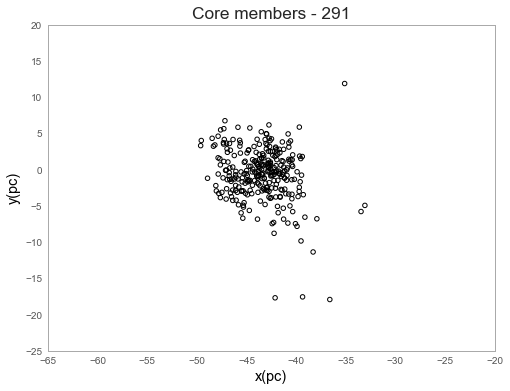


R(Center) = (x,y,z) = (-43.43,-0.51,-16.74) pc
V(Center) = (u,v,w) = (-29.61,-6.95,6.42) km*s^-1

Core member V: 46.55 km*s^-1

R(Center) = (r,theta,z) = (-8343.44,-0.51,10.4) pc
V(Center) = (Vr,Vtheta,Vz) = (-29.62,213.05,6.55) km*s^-1

Core member V: 46.55 km*s^-1


In [476]:
plt.scatter(core1['x'],core1['y'],s=20,edgecolors = 'k',facecolors='none')
plt.scatter(core2['x'],core2['y'],s=20,edgecolors = 'k',facecolors='none')
plt.xlim([-65,-20])
plt.ylim([-25,20])
plt.xlabel('x(pc)')
plt.ylabel('y(pc)')
plt.title('Core members - {}'.format(len(core1)+len(core2)))
plt.show()

print('\nR(Center) = (x,y,z) = ({},{},{}) pc\nV(Center) = (u,v,w) = ({},{},{}) km*s^-1'\
      .format(rnd(np.mean(pd.concat([core1['x'],core2['x']]))),rnd(np.mean(pd.concat([core1['y'],core2['y']]))),\
              rnd(np.mean(pd.concat([core1['z'],core2['z']]))),rnd(np.mean(pd.concat([core1['u'],core2['u']]))),\
              rnd(np.mean(pd.concat([core1['v'],core2['v']]))),rnd(np.mean(pd.concat([core1['w'],core2['w']])))))
core_mean_v_mag = np.sqrt((43.43**2)+(0.51**2)+(16.74**2))
print('\nCore member V: {} km*s^-1'.format(rnd(core_mean_v_mag)))
core1.head()

print('\nR(Center) = (r,theta,z) = ({},{},{}) pc\nV(Center) = (Vr,Vtheta,Vz) = ({},{},{}) km*s^-1'\
      .format(rnd(np.mean(pd.concat([core3['r'],core4['r']]))),rnd(np.mean(pd.concat([core3['theta'],core4['theta']]))),\
              rnd(np.mean(pd.concat([core3['z'],core4['z']]))),rnd(np.mean(pd.concat([core3['Vr'],core4['Vr']]))),\
              rnd(np.mean(pd.concat([core3['Vtheta'],core4['Vtheta']]))),rnd(np.mean(pd.concat([core3['Vz'],core4['Vz']])))))

print('\nCore member V: {} km*s^-1'.format(rnd(core_mean_v_mag)))

In [484]:
data = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/5pc.csv')

# HELIO.csv == astroFrame(data)
HELIO = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/HELIO.csv')
HELIO['id'] = [i for i in range(len(HELIO))]
data.head()

,source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error,parallax,parallax_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,5781834812959489920,236.645693,0.018643,-75.399888,0.019501,9.236133,0.032575,-13.196771,0.041458,0.242497,0.957960,7.674512,0.023794,10.113231,10.429392,9.665930
1,4464022263949414656,245.356079,0.023258,14.620676,0.020737,-54.763548,0.041962,-32.305415,0.038548,-12.975678,0.320910,6.365233,0.036161,10.194319,10.528229,9.729285
2,4464036484584088320,245.225769,0.021291,14.721420,0.017986,-28.392495,0.040309,-6.300816,0.034020,-10.722656,0.928010,7.368490,0.033168,11.904952,12.428617,11.251430
3,4464239692374461824,243.873518,0.028097,13.837664,0.024657,12.851653,0.057041,-15.392789,0.046000,-10.016315,0.527596,5.309226,0.043505,10.264918,10.536487,9.864599
4,4464037004277180800,245.296127,0.022200,14.720871,0.021614,-45.613007,0.039445,18.133144,0.039671,-16.469912,0.469753,6.977435,0.036833,11.561617,12.022272,10.968613


In [498]:
FILT = []

for i in range(len(HELIO)):
    if HELIO['u'][i] >=  -29.61-3 and HELIO['u'][i] <= -29.61+3 and\
    HELIO['v'][i] >= -6.95-3 and HELIO['v'][i] <= -6.95+3 and\
    HELIO['w'][i] >= 6.42-3 and HELIO['w'][i] <= 6.42+3:
        FILT.append(list(HELIO.loc[i]))
        
FILT = pd.DataFrame(FILT,columns = list(HELIO)) 

FILT.head()

,x,y,z,u,v,w,id
0,83.361720,-88.147999,-34.360464,-28.506200,-4.861114,8.406748,14.0
1,71.165014,-92.062374,16.292430,-31.003594,-6.378511,5.192008,252.0
2,-54.053349,-47.443063,-103.202561,-31.172908,-9.031482,6.268559,1515.0
3,-15.766551,-133.876230,27.647501,-28.170992,-5.186068,6.648059,1761.0
4,16.787986,42.059299,-188.641781,-30.492364,-7.015652,7.547610,1777.0


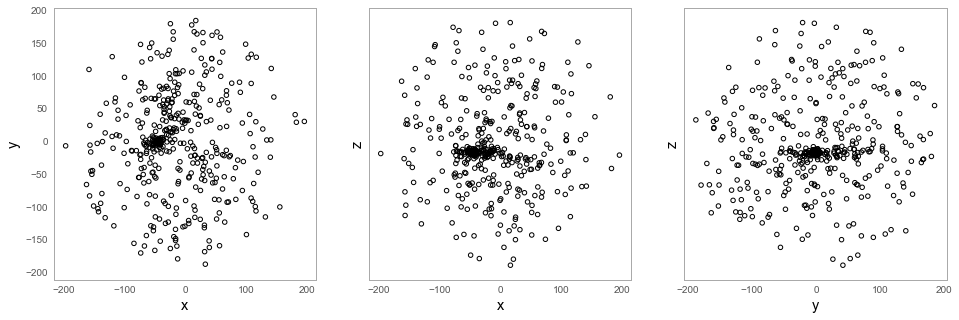

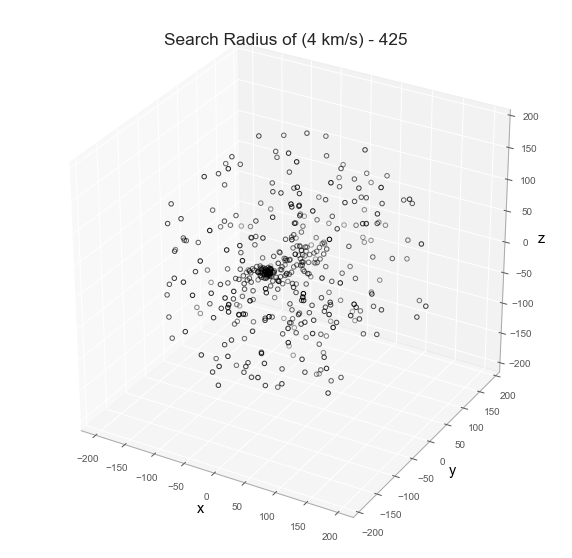

In [499]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,5))
ax1.scatter(FILT['x'],FILT['y'],s=20,edgecolors = 'k',facecolors='none')
ax1.set_xlabel('x'), ax1.set_ylabel('y')
ax2.scatter(FILT['x'],FILT['z'],s=20,edgecolors = 'k',facecolors='none')
ax2.set_xlabel('x'), ax2.set_ylabel('z')
ax3.scatter(FILT['y'],FILT['z'],s=20,edgecolors = 'k',facecolors='none')
ax3.set_xlabel('y'), ax3.set_ylabel('z')
plt.show()

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Search Radius of (4 km/s) - {}'.format(len(FILT)))

ax.scatter3D(FILT['x'], FILT['y'], FILT['z'],s=20,edgecolors = 'k',facecolors='none')
plt.show()

In [512]:
# Spatial Density Filter

stars = []
raw = []

def spherical(x,y,z):
    rho = np.sqrt(x**2+y**2+z**2)
    phi = np.arccos(z/rho)
    theta = np.arctan(y/x)
    lis = [rho,abs(theta),abs(phi)]
    return lis

for o in range(len(FILT)):
    
    count = 0

    x,y,z = FILT['x'][o],FILT['y'][o],FILT['z'][o]
    
    if x - x == 0: dx = -x
    else: dx = x
    if y - y == 0: dy = -y
    else: dy = x
    if z - z == 0: dz = -z
    else: dz = z
    
    for i in range(len(FILT)):
        coords = spherical(FILT['x'][i] + dx, FILT['y'][i] + dy, FILT['z'][i] + dz)
        if coords[0] < 20:
            count += 1
            
    if count > 4: 
        stars.append(list(FILT.loc[o]))
        raw.append(list(data.loc[FILT['id'][o]]))
               
stars = pd.DataFrame(stars,columns = list(FILT))   
raw = pd.DataFrame(raw,columns = list(data))

/Users/landonbuechner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/landonbuechner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


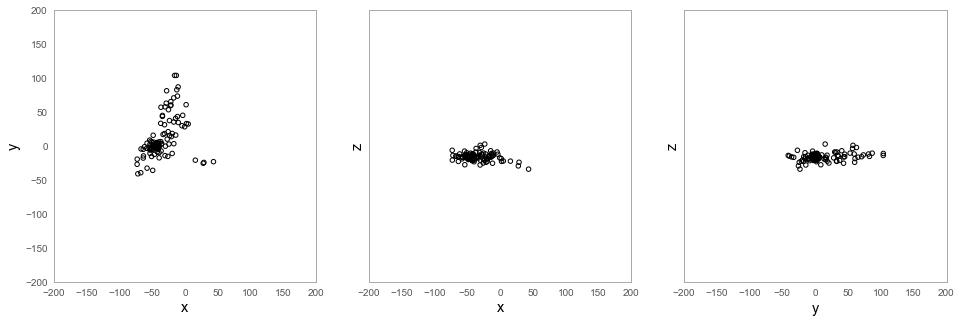

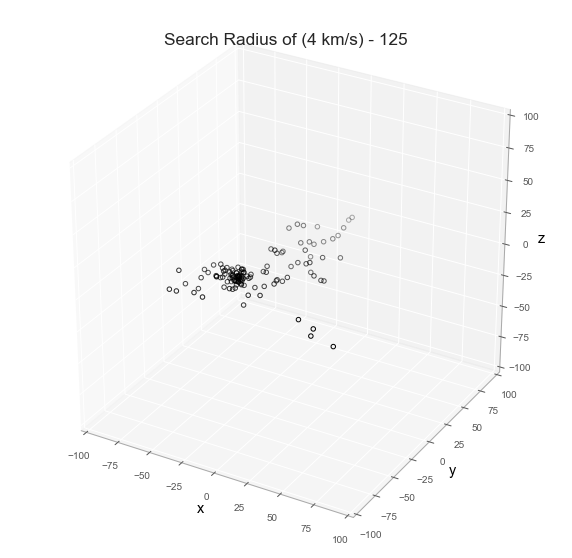

In [515]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,5))

ax1.scatter(stars['x'],stars['y'],s=20,edgecolors = 'k',facecolors='none')
ax1.set_xlabel('x'), ax1.set_ylabel('y')
ax1.set_xlim([-200,200])
ax1.set_ylim([-200,200])

ax2.scatter(stars['x'],stars['z'],s=20,edgecolors = 'k',facecolors='none')
ax2.set_xlabel('x'), ax2.set_ylabel('z')
ax2.set_xlim([-200,200])
ax2.set_ylim([-200,200])

ax3.scatter(stars['y'],stars['z'],s=20,edgecolors = 'k',facecolors='none')
ax3.set_xlabel('y'), ax3.set_ylabel('z')
ax3.set_xlim([-200,200])
ax3.set_ylim([-200,200])

plt.show()

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-100,100])
ax.set_ylim([-100,100])
ax.set_zlim([-100,100])
ax.set_title('Search Radius of (4 km/s) - {}'.format(len(stars)))

ax.scatter3D(stars['x'], stars['y'], stars['z'],s=20,edgecolors = 'k',facecolors='none')
plt.show()

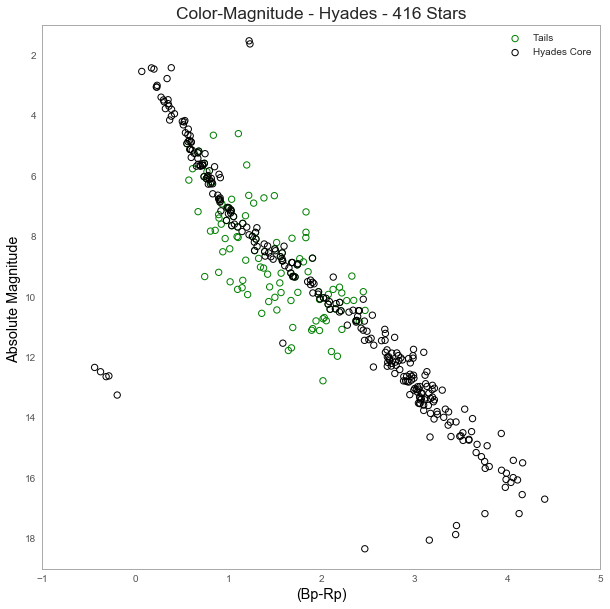

In [530]:
plt.figure(figsize=(10,10))
plt.title('Color-Magnitude - Hyades - {} Stars'.format(len(raw)+len(hya1)+len(hya2)))
plt.xlabel('(Bp-Rp)')
plt.ylabel('Absolute Magnitude ')
plt.xlim([-1,5])
plt.ylim([19,1])

M_g = [abs_mag(raw['phot_g_mean_mag'][i],raw['parallax'][i]) for i in range(len(raw['ra']))]
M_rp = [abs_mag(raw['phot_rp_mean_mag'][i],raw['parallax'][i]) for i in range(len(raw['ra']))]
M_b = [abs_mag(raw['phot_bp_mean_mag'][i],raw['parallax'][i]) for i in range(len(raw['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=40,edgecolors = 'g',facecolors='none')


M_g = [abs_mag(hya1['phot_g_mean_mag'][i],hya1['parallax'][i]) for i in range(len(hya1['ra']))]
M_rp = [abs_mag(hya1['phot_rp_mean_mag'][i],hya1['parallax'][i]) for i in range(len(hya1['ra']))]
M_b = [abs_mag(hya1['phot_bp_mean_mag'][i],hya1['parallax'][i]) for i in range(len(hya1['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=40,edgecolors = 'k',facecolors='none')


M_g = [abs_mag(hya2['phot_g_mean_mag'][i],hya2['parallax'][i]) for i in range(len(hya2['ra']))]
M_rp = [abs_mag(hya2['phot_rp_mean_mag'][i],hya2['parallax'][i]) for i in range(len(hya2['ra']))]
M_b = [abs_mag(hya2['phot_bp_mean_mag'][i],hya2['parallax'][i]) for i in range(len(hya2['ra']))]
CI = color(M_rp,M_b)
plt.scatter(CI, M_g,marker='o',s=40,edgecolors = 'k',facecolors='none')
plt.legend(['Tails','Hyades Core'])
plt.show()

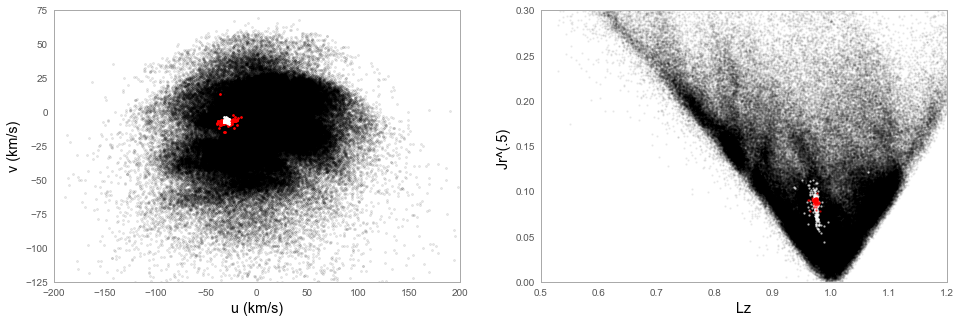

In [828]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel

aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,c=False) 

def stae(df):
    lis = []
    for i in range(len(df)):
        op= Orbit(vxvv=[df['ra'][i],df['dec'][i],1/(df['parallax'][i]/1000)/1000,\
               df['pmra'][i],df['pmdec'][i],df['radial_velocity'][i]],radec=True)
        lis.append(aAS(op))
    return lis
        
#staeckel = pd.DataFrame(stae(data),columns = ['Jr','Lz','Jz'])
#staeckel.to_csv('staeckel_data.csv', encoding='utf-8', index=False)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,5))

ax1.scatter(HELIO['u'],HELIO['v'],s=4,alpha = 0.075,c = 'k')
ax1.scatter(core1['u'],core1['v'],s = 3, c = 'r')
ax1.scatter(core2['u'],core2['v'],s = 3, c = 'r')
ax1.scatter(stars['u'],stars['v'],s = 3, c = 'w')
ax1.set_xlabel('u (km/s)')
ax1.set_ylabel('v (km/s)')
ax1.set_xlim([-200,200])
ax1.set_ylim([-125,75])

staeckel = pd.read_csv('/Users/landonbuechner/Documents/Git Hub Repositories/TidalTails/staeckel_data.csv')
tail_stae = pd.DataFrame(stae(raw),columns = ['Jr','Lz','Jz'])
coreA =  pd.DataFrame(stae(hya1),columns = ['Jr','Lz','Jz'])
coreB =  pd.DataFrame(stae(hya2),columns = ['Jr','Lz','Jz'])

ax2.scatter(staeckel['Lz'],(staeckel['Jr'])**.5,s=2,alpha = 0.05,c = 'k')
ax2.scatter(coreA['Lz'],(coreA['Jr'])**.5,s=2,c= 'w',alpha = 0.5)
ax2.scatter(coreB['Lz'],(coreB['Jr'])**.5,s=2,c= 'w',alpha = 0.5)
ax2.scatter(tail_stae['Lz'],(tail_stae['Jr'])**.5,s=2,c= 'r',alpha = 0.5)
ax2.set_xlabel('Lz')
ax2.set_ylabel('Jr^(.5) ')
ax2.set_xlim([0.5,1.2])
ax2.set_ylim([0,.3])
plt.show()

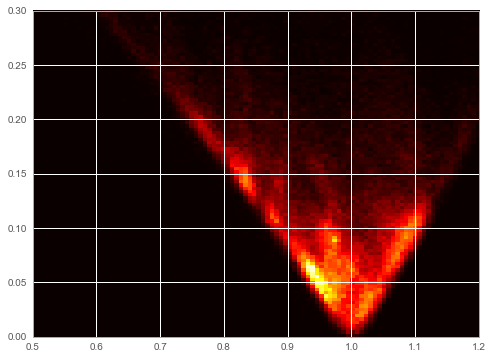

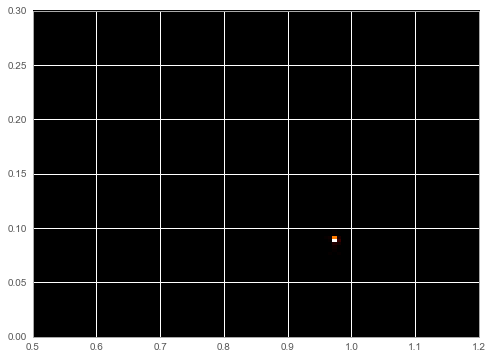

In [827]:
a = staeckel['Lz']
b = (staeckel['Jr'])**.5
c = tail_stae['Lz']
d = (tail_stae['Jr'])**.5

plt.hist2d(a, b, (100, 100), range= np.array([[0.5,1.2], [0,.3]]), cmap='hot')
plt.show()

plt.hist2d(c, d, (100, 100), range= np.array([[0.5,1.2], [0,.3]]))
plt.show()